# PERMUTATION ENTROPY PARAMETER SELECTION
### http://firaskhasawneh.com/assets/repo_docs/PE_parameter_selection_doc/PE_param_selection.html

In [374]:
import sys,os,glob
import numpy as np
import pandas as pd
sys.path.insert(0, os.path.abspath('PE_parameter_selection/PE_parameter_functions'))
import MI_delay,  autocorrelation, MsPE, delay_LMS,PAMI_delay,FNN_n
import seaborn as sns
from tqdm import notebook
import tsfel
sys.path.insert(0, os.path.abspath('MMPE'))
import mmpe_util

In [355]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'


In [357]:
def get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer):    

    subject_list = []
    all_data = []
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        series = series.T
        series['network'] = schafer['network']
        series_nolimbic = series[series.network!='Limbic']
        del series_nolimbic["network"]
        df_series = series_nolimbic.T
        all_data.append(df_series.values)
        subject_list.append(subject)
  
    return all_data, subject_list
    

def get_all_data(scans, stimuli,subjects, dirpath, parcel,schafer): 
    all_c = []
    all_subjects = []

    for scan in scans:

        for stimulus in stimuli:
  
            all_data, subject_list = get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer)
            all_subjects = all_subjects +  subject_list
            all_c = all_c + all_data
          
    return all_c, all_subjects

In [358]:
occ_pre, subjects_list_occ_pre = get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
occ_post, subjects_list_occ_post =  get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

all_occ = occ_pre + occ_post
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)

cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

X_occ = np.swapaxes(np.dstack(all_occ), 0,2)
y_occ = np.array(y_occ)

X_occ.shape

(46, 376, 600)

In [359]:
ts = X_occ[1,6,:]

## TIME DELAY

### MUTUAL INFORMATION
##### location of the first minima in the mutual information vs delay plot


/home/jarvis/Documentos/catalina/hmm/PE_parameter_selection/PE_parameter_functions/MI_delay.py:503: RuntimeWarning: divide by zero encountered in log
  
/home/jarvis/Documentos/catalina/hmm/PE_parameter_selection/PE_parameter_functions/MI_delay.py:503: RuntimeWarning: invalid value encountered in multiply
  


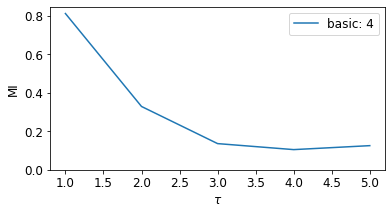

4

In [320]:
ts = X_occ[1,1,:]
MI_delay.MI_for_delay(ts, plotting=True)

In [321]:
subject_tau = []
for subject_series in X_occ:
    tau = []
    for ts in subject_series:
        tau.append(MI_delay.MI_for_delay(ts))
    subject_tau.append(np.array(tau))
array_tau = np.array(subject_tau)    

In [322]:
df_arrray_tau = pd.DataFrame(array_tau)
df_arrray_tau["subject"] = subjects_occ
df_arrray_tau["group"] = y_occ
df_arrray_tau_melt = pd.melt(df_arrray_tau, id_vars=["group", "subject"], var_name="roi", value_name="tau")

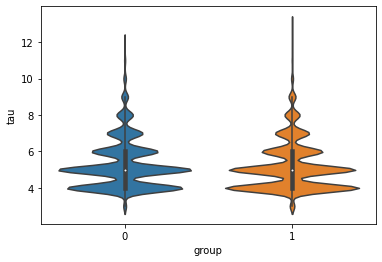

In [323]:
ax = sns.violinplot(x="group", y="tau", data=df_arrray_tau_melt)

In [324]:
print("min_value_tau: ", array_tau.min(),"median: ", np.median(array_tau), "max_value_tau: ", array_tau.max())

min_value_tau:  3 median:  5.0 max_value_tau:  13


### Auto-correlation
#### This function takes a time series and uses AC to find the optimum delay based on the correlation being less than a specified cutoff (default is 1/e, which is approximately 0.36788).

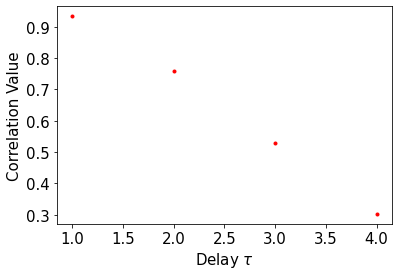

4

In [332]:
autocorrelation.autoCorrelation_tau(ts, plotting=True)

In [333]:
subject_tau_ac = []
for subject_series in X_occ:
    tau = []
    for ts in subject_series:
        tau.append(autocorrelation.autoCorrelation_tau(ts))
    subject_tau_ac.append(np.array(tau))
array_tau_ac = np.array(subject_tau_ac)    

In [334]:
df_arrray_tau_ac = pd.DataFrame(array_tau_ac)
df_arrray_tau_ac["subject"] = subjects_occ
df_arrray_tau_ac["group"] = y_occ
df_arrray_tau_ac_melt = pd.melt(df_arrray_tau_ac, id_vars=["group", "subject"], var_name="roi", value_name="tau")

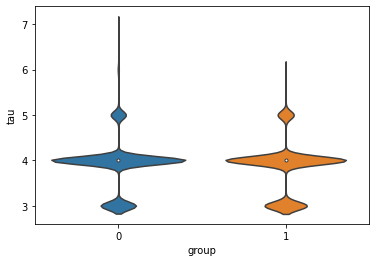

In [335]:
ax = sns.violinplot(x="group", y="tau", data=df_arrray_tau_ac_melt)

In [336]:
print("min_value_tau: ", array_tau_ac.min(),"median: ", np.median(array_tau_ac), "max_value_tau: ", array_tau_ac.max())

min_value_tau:  3 median:  4.0 max_value_tau:  7


 ### Multi-scale Permutation Entropy
 #### This function takes a time series and uses Multi-scale Permutation Entropy (MsPE) to find the optimum delay based on the first maxima in the MsPE plot

<Figure size 432x288 with 0 Axes>

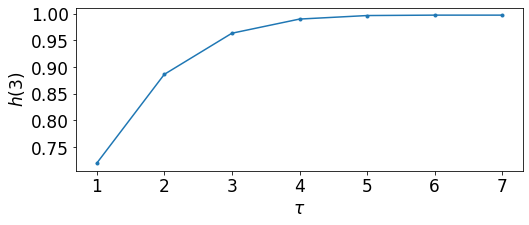

6

In [337]:
int(MsPE.MsPE_tau(ts, plotting = True))

In [338]:
subject_tau_mspe = []
for subject_series in X_occ:
    tau = []
    for ts in subject_series:
        tau.append(int(MsPE.MsPE_tau(ts)))
    subject_tau_mspe.append(np.array(tau))
array_tau_mspe = np.array(subject_tau_mspe)    

In [339]:
df_arrray_tau_mspe = pd.DataFrame(array_tau_mspe)
df_arrray_tau_mspe["subject"] = subjects_occ
df_arrray_tau_mspe["group"] = y_occ
df_arrray_tau_mspe_melt = pd.melt(df_arrray_tau_mspe, id_vars=["group", "subject"], var_name="roi", value_name="tau")

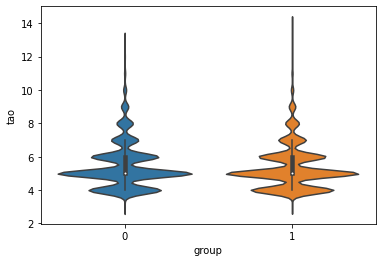

In [261]:
ax = sns.violinplot(x="group", y="tao", data=df_arrray_tao_mspe_melt)

In [340]:
print("min_value_tau: ", array_tau_mspe.min(),"median: ", np.median(array_tau_mspe),"min_value_tau: ", array_tau_mspe.max())

min_value_tau:  3 median:  5.0 min_value_tau:  14


### Statistical analysis of the Fourier spectrum
#### This function a statistical analysis (using the least median of squares) of the fourier spectrum (FFT) from a time series to detect the greatest signficant frequency, which is then used to select the delay (tau) from the samping rate criteria developed in On the 0/1 test for chaos in continuous systems by Melosik and Marszalek.

0.10301003344481606


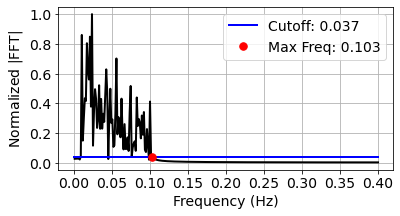

Permutation Embedding Delay: 2


In [263]:
fs = 1/1.25
tau = delay_LMS.LMSforDelay(ts, fs, plotting = True)
print('Permutation Embedding Delay: ' + str(int(tau)))

In [264]:
subject_tau_lms = []
for subject_series in X_occ:
    tau = []
    for ts in subject_series:
        tau.append(int(delay_LMS.LMSforDelay(ts, fs)))
    subject_tau_lms.append(np.array(tau))
array_tau_lms = np.array(subject_tau_lms)    

0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10301003344481606
0.10434782608695653
0.10301003344481606
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10434782608695653
0.10836120401337794


0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10434782608695653
0.105685618729097
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.105685618729097
0.09899665551839466
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10167224080267559
0.10836120401337794
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.11103678929765888
0.10033444816053513
0.10969899665551841
0.10702341137123747
0.10434782608695653
0.10033444816053513
0.11103678929765888
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10969899665551841
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10

0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559


0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10836120401337794
0.11237458193979935
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.105685618729097
0.10434782608695653
0.10969899665551841
0.10301003344481606
0.10301003344481606
0.10702341137123747
0.10836120401337794
0.11237458193979935
0.10969899665551841
0.105685618729097
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10434782608695653
0.11103678929765888
0.11237458193979935
0.10301003344481606
0.10434782608695653
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.1110

0.10167224080267559
0.10167224080267559
0.10836120401337794
0.105685618729097
0.10301003344481606
0.105685618729097
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10702341137123747
0.11103678929765888
0.10702341137123747
0.10969899665551841
0.10033444816053513
0.105685618729097
0.10033444816053513
0.10702341137123747
0.11237458193979935
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10434782608695653
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10301003344481606
0.11103678929765888
0.10167224080267559
0.11237458193979935
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10702341137123747
0.10702341137123747
0.10301003344481606
0.10434782608695653
0.10033444816053513
0.100334

0.10434782608695653
0.10033444816053513
0.10167224080267559
0.10969899665551841
0.10434782608695653
0.10434782608695653
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10434782608695653
0.10836120401337794
0.105685618729097
0.11103678929765888
0.10301003344481606
0.10434782608695653
0.10434782608695653
0.10702341137123747
0.10434782608695653
0.10969899665551841
0.105685618729097
0.105685618729097
0.10301003344481606
0.11103678929765888
0.105685618729097
0.10836120401337794
0.10702341137123747
0.10167224080267559
0.105685618729097
0.105685618729097
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.105685618729097
0.10167224080267559
0.10033444816053513
0.105685618729097
0.10702341137123747
0.10836120401337794
0.10167224080267559
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.1123745819397993

0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10434782608695653
0.09899665551839466
0.09899665551839466
0.10702341137123747
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10702341137123747
0.10702341137123747
0.10836120401337794
0.10167224080267559
0.10033444816053513
0.

0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.09899665551839466
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513


0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10301003344481606
0.11103678929765888
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10836120401337794
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10167224080267559
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10033444816053513


0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10836120401337794
0.10434782608695653
0.10033444816053513
0.1137123745819398
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0

0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513


0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10969899665551841
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10033444816053513
0.105685618729097
0.10033444816053513
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10301003344481606
0.10434782608695653
0.11103678929765888
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.11

0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10702341137123747
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.105685618729097
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10434782608695653
0.10434782608695653
0.10836120401337794
0.10434782608695653
0.10434782608695653
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10

0.10301003344481606
0.10702341137123747
0.10301003344481606
0.10167224080267559
0.105685618729097
0.10702341137123747
0.105685618729097
0.10301003344481606
0.10033444816053513
0.105685618729097
0.09899665551839466
0.10301003344481606
0.105685618729097
0.10702341137123747
0.10167224080267559
0.10033444816053513
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10969899665551841
0.10033444816053513
0.10836120401337794
0.10434782608695653
0.10033444816053513
0.09899665551839466
0.10702341137123747
0.10702341137123747
0.10434782608695653
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10167224080267559
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10033444

0.10301003344481606
0.10434782608695653
0.10167224080267559
0.105685618729097
0.10702341137123747
0.10702341137123747
0.10836120401337794
0.10434782608695653
0.105685618729097
0.10969899665551841
0.10434782608695653
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10434782608695653
0.10836120401337794
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10969899665551841
0.10167224080267559
0.10033444816053513
0.105685618729097
0.10301003344481606
0.10033444816053513
0.10702341137123747
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10434782608695653
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.101672

0.10033444816053513
0.105685618729097
0.10033444816053513
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10836120401337794
0.10702341137123747
0.10301003344481606
0.10836120401337794
0.10167224080267559
0.105685618729097
0.10301003344481606
0.10033444816053513
0.10836120401337794
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10167224080267559
0.09899665551839466
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.1003

0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.0976588628762542
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10836120401337794
0.10033444816053513
0.10836120401337794
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.11103678929765888
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10167224080267559
0

0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10702341137123747
0.09899665551839466
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10167224080267559
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.09899665551839466
0.10434782608695653
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10702341137123747
0.10033444816053513
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10434782608695653
0.

0.10033444816053513
0.10969899665551841
0.10702341137123747
0.105685618729097
0.10836120401337794
0.10969899665551841
0.10301003344481606
0.09899665551839466
0.10702341137123747
0.10836120401337794
0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10702341137123747
0.10301003344481606
0.09899665551839466
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.09899665551839466
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10434782608695653
0.11237458193979935
0.10301003344481606
0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10

0.10167224080267559
0.10434782608695653
0.10702341137123747
0.10167224080267559
0.105685618729097
0.10434782608695653
0.105685618729097
0.10702341137123747
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10434782608695653
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.105685618729097
0.10702341137123747
0.105685618729097
0.10836120401337794
0.10301003344481606
0.10434782608695653
0.10434782608695653
0.11103678929765888
0.10969899665551841
0.10434782608695653
0.10434782608695653
0.10434782608695653
0.10167224080267559
0.10167224080267559
0.1137123745819398
0.10033444816053513
0.10702341137123747
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.105685618729097
0.10033444816053513
0.10301003344481606
0.10434782608695653
0.105685618729097
0.10301003344481606
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.11237458193979935
0.10167224080

0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10836120401337794
0.10301003344481606
0.10167224080267559
0.09899665551839466
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10836120401337794
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10167224080267559
0.09899665551839466
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.11638795986622075
0.11103678929765888
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606


0.10702341137123747
0.10836120401337794
0.10434782608695653
0.10836120401337794
0.10301003344481606
0.10167224080267559
0.10702341137123747
0.10836120401337794
0.10167224080267559
0.10969899665551841
0.10167224080267559
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10434782608695653
0.10167224080267559
0.10167224080267559
0.10836120401337794
0.10167224080267559
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.11103678929765888
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.

0.11237458193979935
0.1137123745819398
0.10702341137123747
0.105685618729097
0.10702341137123747
0.10702341137123747
0.10434782608695653
0.105685618729097
0.10033444816053513
0.11505016722408028
0.10167224080267559
0.10033444816053513
0.11103678929765888
0.10836120401337794
0.10702341137123747
0.10969899665551841
0.105685618729097
0.10434782608695653
0.10702341137123747
0.10167224080267559
0.105685618729097
0.10702341137123747
0.1137123745819398
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.105685618729097
0.105685618729097
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.103010033444

0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.105685618729097
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.105685618729097
0.10434782608695653
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.105685618729097
0.10434782608695653
0.10167224080267559
0.10702341137123747
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10836120401337794
0.10033444816053513
0.10836120401337794
0.10167224080267559
0.10301003344481606
0.10301003344481606
0.108361

0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10702341137123747
0.10167224080267559
0.10969899665551841
0.11505016722408028
0.10434782608695653
0.105685618729097
0.10033444816053513
0.10167224080267559
0.11103678929765888
0.10033444816053513
0.11103678929765888
0.10836120401337794
0.10836120401337794
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10702341137123747
0.105685618729097
0.1137123745819398
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10702341137123747
0.11103678929765888
0.10836120401337794
0.09899665551839466
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10434782608695653
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10301003344481606
0.100

0.10167224080267559
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10702341137123747
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.09899665551839466
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10836120401337794
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.105685618729097
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.105685618729097
0.10033444816053513
0.10167224080267559
0.10702341137123747
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10969899665551841
0.10033444816053513
0.10033444816053513
0.10434782608695653
0.105685618729097
0.09899665551839466
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.1016

0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10434782608695653
0.10301003344481606
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10702341137123747
0.10836120401337794
0.105685618729097
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10301003344481606
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10836120401337794
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10702341137123747
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10167224080267559
0.10434782608695653
0.10167224080267559
0.

0.10167224080267559
0.10301003344481606
0.11237458193979935
0.10301003344481606
0.105685618729097
0.10033444816053513
0.10301003344481606
0.105685618729097
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10167224080267559
0.105685618729097
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.105685618729097
0.10836120401337794
0.1137123745819398
0.11237458193979935
0.11772575250836122
0.1137123745819398
0.10836120401337794
0.105685618729097
0.10702341137123747
0.105685618729097
0.11906354515050169
0.10702341137123747
0.1137123745819398
0.11772575250836122
0.10702341137123747
0.10301003344481606
0.10836120401337794
0.10033444816053513
0.10301003344481606
0.1137123745819398
0.10033444816053513
0.105685618729097
0.10434782608695653
0.10167224080267559
0.11103678929765888
0.11638795986622075
0.10301003344481606
0.1137123745819398
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10033444816053513
0.10167224080267559

0.10033444816053513
0.10301003344481606
0.105685618729097
0.105685618729097
0.10969899665551841
0.10301003344481606
0.10836120401337794
0.10434782608695653
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.105685618729097
0.10434782608695653
0.10301003344481606
0.10167224080267559
0.11237458193979935
0.10434782608695653
0.10836120401337794
0.10836120401337794
0.10434782608695653
0.10969899665551841
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.105685618729097
0.10167224080267559
0.105685618729097
0.10167224080267559
0.11237458193979935
0.105685618729097
0.11103678929765888
0.10836120401337794
0.10836120401337794
0.10301003344481606
0.10434782608695653
0.10434782608695653
0.10434782608695653
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10301003344481606
0.10167224080267559
0.10702341137123747
0.105685618729097
0.10167224080267559
0.10702341137123747
0.10969899665551841
0.10702341137123747
0.10167224080267

0.10434782608695653
0.10033444816053513
0.105685618729097
0.10434782608695653
0.105685618729097
0.10702341137123747
0.10301003344481606
0.10033444816053513
0.10969899665551841
0.10301003344481606
0.11237458193979935
0.10434782608695653
0.10033444816053513
0.10836120401337794
0.10702341137123747
0.10167224080267559
0.10033444816053513
0.10434782608695653
0.10167224080267559
0.10301003344481606
0.10434782608695653
0.10301003344481606
0.10301003344481606
0.10301003344481606
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.09899665551839466
0.09899665551839466
0.10301003344481606
0.105685618729097
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.1003

0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10301003344481606
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10434782608695653
0.10033444816053513
0.10301003344481606
0.10033444816053513
0.10301003344481606
0.10702341137123747
0.09899665551839466
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10167224080267559
0.0976588628762542
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.105685618729097
0.10033444816053513
0.10033444816053513
0.10033444816053513
0.1

In [265]:
df_arrray_tau_lms = pd.DataFrame(array_tau_lms)
df_arrray_tau_lms["subject"] = subjects_occ
df_arrray_tau_lms["group"] = y_occ
df_arrray_tau_lms_melt = pd.melt(df_arrray_tau_lms, id_vars=["group", "subject"], var_name="roi", value_name="tau")

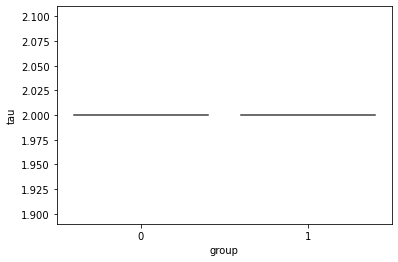

In [266]:
ax = sns.violinplot(x="group", y="tau", data=df_arrray_tau_lms_melt)

### Permutation Auto Mutual Information (PAMI) 
#### This function implements the mulutal information of permutations to find the delay (tau) that causes the first minima in the mutual information between permutations.

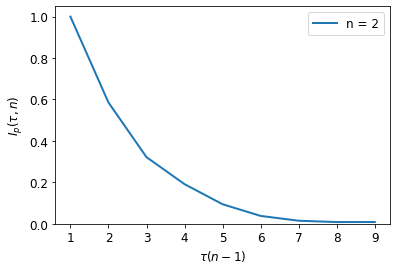

Delay from PAMI:  2


In [342]:
tau = PAMI_delay.PAMI_for_delay(ts, plotting = True)
print('Delay from PAMI: ',tau)

In [343]:
subject_tau_pami = []
for subject_series in notebook.tqdm(X_occ):
    tau = []
    for ts in subject_series:
        tau.append(PAMI_delay.PAMI_for_delay(ts))
    subject_tau_pami.append(np.array(tau))
array_tau_pami = np.array(subject_tau_pami)    

In [344]:
df_arrray_tau_pami = pd.DataFrame(array_tau_pami)
df_arrray_tau_pami["subject"] = subjects_occ
df_arrray_tau_pami["group"] = y_occ
df_arrray_tau_pami_melt = pd.melt(df_arrray_tau_pami, id_vars=["group", "subject"], var_name="roi", value_name="tau")

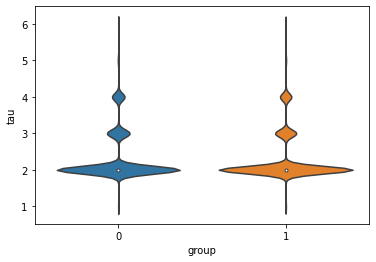

In [345]:
ax = sns.violinplot(x="group", y="tau", data=df_arrray_tau_pami_melt)

In [353]:
print("min_value_tau: ", array_tau_pami.min(),"median: ", np.median(array_tau_pami), "max_value_tau: ", array_tau_pami.max())

min_value_tau:  1 median:  2.0 max_value_tau:  6


## DIMENSION


 ### Multi-scale Permutation Entropy 
 #### This function returns a suitable embedding dimension, given a time series and embedding delay, based on the dimenion normalized MsPE at the optimum delay for a range of dimensions n.

<Figure size 432x288 with 0 Axes>

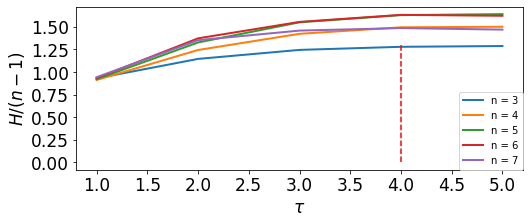

Embedding Dimension:   6


In [347]:
tau = 4
#m_s and m_e are the starting and ending dimensions n to search through
m_s, m_e = 3, 7
n = MsPE.MsPE_n(ts, tau, m_s, m_e, plotting = True)
print('Embedding Dimension:   '+str(n))

In [348]:
subject_n_mspe = []
for subject_series in X_occ:
    n = []
    for ts in subject_series:
        n.append(MsPE.MsPE_n(ts, tau, m_s, m_e))
    subject_n_mspe.append(np.array(n))
array_n_mspe = np.array(subject_n_mspe)  

In [349]:
df_arrray_n_mspe = pd.DataFrame(array_n_mspe)
df_arrray_n_mspe["subject"] = subjects_occ
df_arrray_n_mspe["group"] = y_occ
df_arrray_n_mspe_melt = pd.melt(df_arrray_n_mspe, id_vars=["group", "subject"], var_name="roi", value_name="dimension")

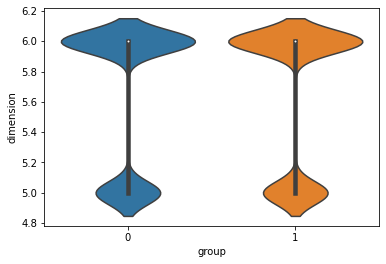

In [350]:
ax = sns.violinplot(x="group", y="dimension", data=df_arrray_n_mspe_melt)

In [352]:
print("min_value_n: ", array_n_mspe.min(),"median: ", np.median(array_n_mspe), "max_value_tau: ", array_n_mspe.max())

min_value_n:  5 median:  6.0 max_value_tau:  6


### False Nearest Neighbors (FNN) 
#### This function implements the False Nearest Neighbors (FNN) algorithm described by Kennel et al. to select the minimum embedding dimension.

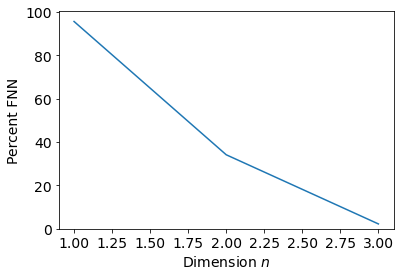

FNN embedding Dimension:  3


In [305]:
tau = 4
perc_FNN, n = FNN_n.FNN_n(ts, tau, plotting = True)
print('FNN embedding Dimension: ',n)

In [306]:
subject_n_fnn = []
for subject_series in X_occ:
    dimensions = []
    for ts in subject_series:
        perc_FNN, n = FNN_n.FNN_n(ts, tau)
        dimensions.append(n)
    subject_n_fnn.append(np.array(dimensions))
array_n_fnn = np.array(subject_n_fnn)  

/home/jarvis/Documentos/catalina/hmm/PE_parameter_selection/PE_parameter_functions/FNN_n.py:73: RuntimeWarning: divide by zero encountered in true_divide
  num1 = np.heaviside(np.divide(abs(tsrecon[ind_m,-1]-tsrecon[ind,-1]),Dm)-Rtol,0.5)
/home/jarvis/Documentos/catalina/hmm/PE_parameter_selection/PE_parameter_functions/FNN_n.py:73: RuntimeWarning: invalid value encountered in true_divide
  num1 = np.heaviside(np.divide(abs(tsrecon[ind_m,-1]-tsrecon[ind,-1]),Dm)-Rtol,0.5)


In [307]:
df_arrray_n_fnn = pd.DataFrame(array_n_fnn)
df_arrray_n_fnn["subject"] = subjects_occ
df_arrray_n_fnn["group"] = y_occ
df_arrray_n_fnn_melt = pd.melt(df_arrray_n_fnn, id_vars=["group", "subject"], var_name="roi", value_name="dimension")

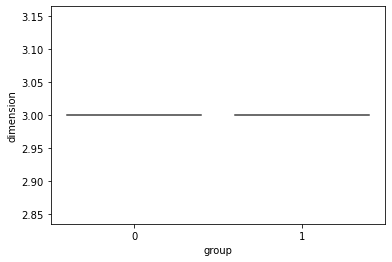

In [308]:
ax = sns.violinplot(x="group", y="dimension", data=df_arrray_n_fnn_melt)

In [309]:
print("min_value_n: ", array_n_fnn.min(),"median: ", np.median(array_n_fnn))

min_value_n:  3 median:  3.0


In [387]:
 pe_ws[0].shape

(2, 30)